# 情報活用講座：　ケモインフォマテックス 編　
# 第４回：　フラグメントカウントからのQSPR 

## 底本
船津 公人、柴山 翔二郎 **『実践 マテリアルズインフォマティクス　Pythonによる材料設計のための機械学習』**、近代科学社、2020  
第５章　記述子計算


## データセット
delaney-processed.csvは1128化合物の水溶解度についてのデータセットです。このデータセットは、Delaneyの論文『ESOL: Estimating Aqueous Solubility Directly from Molecular Structure』[1] で発表されたもので、分子の化学的特性とその生物学的活性の関係を調査するために使用されます。

[1] John S. Delaney, "ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure", J. Chem. Inf. Comput. Sci. 44, 1000–1005 (2004) (DOI: 10.1021/ci034243x)  

Delaney-processed.csvは、分子の化学構造とその物理的・化学的特性の情報を含んでいます。具体的には、分子の化学式、SMILES表記、分子量、融点、沸点、溶解度などが含まれており、これらの特性は薬物探索や環境影響評価などの目的で使用されています。


1. Compound ID	：化合物ID
1. ESOL predicted log solubility in mols per litre　：log水溶解度の予測値	
1. Minimum Degree：　最小次数	
1. Molecular Weight：分子量	
1. Number of H-Bond Donors	：　水素結合に関与するDonor数
1. Number of Rings	：芳香環の数	
1. Number of Rotatable Bonds　：　回転可能結合数	
1. Polar Surface Area　：　極性表面積	
1. measured log solubility in mols per litre：log水溶解度の実測値	
1. smiles：SMILES表記


## pythonライブラリ

**NumPy**：　高性能の数値計算やデータ処理に特化したPythonのライブラリです。NumPyは多次元の配列や行列を効率的に操作する機能を提供し、科学技術計算やデータ解析の分野で広く使用されています。

**Pandas**：　データ操作と解析のための高レベルのPythonライブラリです。Pandasは、テーブル形式のデータを効率的に処理し、データのフィルタリング、変換、集約、および結合などの機能を提供します。データの整形やクリーニング、欠損値の処理などを容易に行うことができます。

**Matplotlib**：　Pythonでデータを可視化するための強力なライブラリです。Matplotlibは、グラフや図を描画するための多様な機能を提供し、折れ線グラフ、ヒストグラム、散布図、バーチャートなどの多くのプロットスタイルをサポートしています。データの傾向や関係性を視覚的に理解するための強力なツールです。

**RDKit**：　RDKitは、化学情報学や薬学の分野で広く使用されるオープンソースのソフトウェア開発キットです。RDKitはPythonで実装されており、様々な化学情報の処理や分子の構造解析、化学反応の予測などをサポートします。

# Google Colabにおける環境設定
google colab環境でなければ実行不要

In [ ]:
!pip install rdkit-pypi
!pip install mordred
!git clone https://github.com/ARIM-Training/Training_python_4.git
%cd Training_python_4

## 1.分子構造データの読み込み
### ライブラリのインポート

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from rdkit.Chem import MolFromSmarts, MolFromSmiles
from rdkit.Chem.Descriptors import descList
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

from warnings import filterwarnings
filterwarnings('ignore')# 警告を無視

### サンプルファイルの読み込み
第一回と同じく「data/delaney-solubility」フォルダーにあるdelaney-processed.csvをpandasの`read_csv()`で読み込みます。RDkitの`MolFromSmiles`関数を[smiles]列に適用してmol構造への変換オブジェクトを[mol]列とする流れも第一回と同じです。

In [2]:
df = pd.read_csv('./data/delaney-solubility/delaney-processed.csv')
df['Mol'] = df['smiles'].apply(MolFromSmiles)
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,Mol
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x00000222AA3...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x00000222AA3...
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x00000222AA3...
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x00000222AA3...
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x00000222AA3...
...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,<rdkit.Chem.rdchem.Mol object at 0x00000222AB3...
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x00000222AB3...
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x00000222AB3...
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,<rdkit.Chem.rdchem.Mol object at 0x00000222AB3...


## 2. フラグメントカウント　（P.55）

分子のフラグメントとは、分子を構成する部分構造や断片のことで、独自の性質や機能を持つ化学的な単位です。フラグメント化することで、その分子の性質をより詳細に理解することのほか、化学反応や相互作用の解析に役立ちます。

ケモインフォマティクスは、化学情報学とコンピュータ科学を組み合わせた分野であり、特に化合物の構造や性質を扱います。SMARTS（SMArty Language for Structure）は、化合物の構造やサブ構造を指定するために使用され、化学反応の予測や特定の化合物の検索など、さまざまなケモインフォマティクスのタスクで利用されます。

SMARTSは、分子の原子、結合、および環を指定するための特殊な記号や文字列パターンを使用します。例えば、アルコール官能基（OH）を持つ化合物をSMARTSで表現すると、"[OH]"というパターンが使用されます。このようなSMARTSパターンを使用することで、大規模な化合物データベース内でアルコール官能基を持つ化合物を効率的に検索することができます。


ここでは、delaney-solubilityの1128化合物について、ベンゼン環のフラグメントを含む化合物について集計する流れを見てみることにします。

In [3]:
# ベンゼン環の数え上げ
def count_rings(mol):
    fragment = MolFromSmarts('c1ccccc1')
    ret = mol.GetSubstructMatches(fragment)
    n_rings = len(ret)
    return n_rings

【解説】  `GetSubstructMatches()`メソッド  
`GetSubstructMatches()`メソッドは、引数としてサブ構造のパターンを持つ別のMolオブジェクトを受け取りますが、引数にターゲットするSMARTSを入力することでそのサブ構造が含まれるかの検索等が行えます。

以下は、`GetSubstructMatches()`メソッドの基本的な使用法の例です。この例では、`CCOc1ccc2nc(S(N)(=O)=O)sc2c1`というSMILES表記で表される化学構造から、`c1ccsc1`というサブストラクチャのサブ構造に一致する部分構造を見つけます。

```python
from rdkit import Chem

# Molオブジェクトの作成
mol = Chem.MolFromSmiles('CCOc1ccc2nc(S(N)(=O)=O)sc2c1')

# サブストラクチャのパターンを作成
substructure = Chem.MolFromSmarts('c1ccsc1')

# サブストラクチャに一致する部分構造の検索
matches = mol.GetSubstructMatches(substructure)

# 一致する部分構造の原子のインデックスを表示
for match in matches:
    print(match)
```

DataFrameの特定の列（Molという列名）に対して関数（funcという関数名）を適用し、その結果をcount変数に格納することにします。1128化合物に対してベンゼン環を含む個数が計算されました。それを次にヒストグラムとして可視化すると下記のようになります。

In [4]:
func = count_rings 
count = df['Mol'].apply(func)
count

0       1
1       1
2       0
3       5
4       0
       ..
1123    0
1124    0
1125    0
1126    0
1127    1
Name: Mol, Length: 1128, dtype: int64

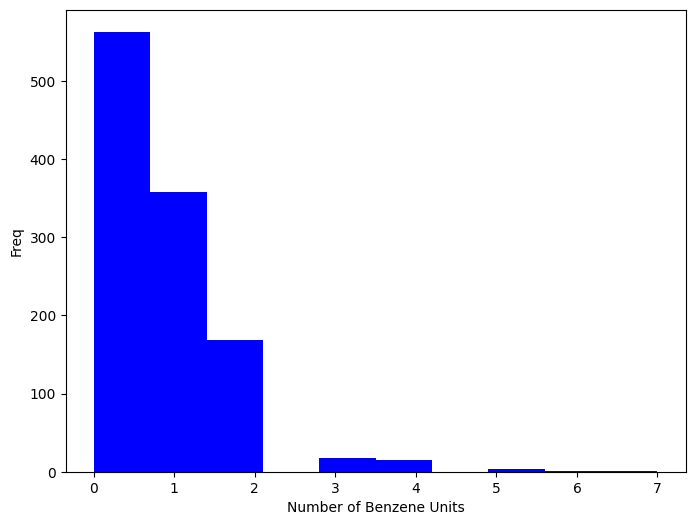

In [5]:
# 図5.1　六員環の出現回数
fig = plt.subplots(figsize=(8, 6))
plt.hist(count, color ='blue')

plt.xlabel('Number of Benzene Units')
plt.ylabel('Freq')

plt.show()

## 【参考】部分構造検索

RDKitは、化学情報学のための強力なツールキットであり、類似化合物の検索や比較に使用することができます。類似化合物の検索は、主に2つの方法を使用して行われます。

* **構造類似性検索（Structure Similarity Search）**: ある化合物に類似した構造を持つ他の化合物を検索する方法です。この方法では、指定された化合物との構造的な類似性を計算し、閾値を設定して類似度の高い化合物を抽出します。RDKitでは、MorganフィンガープリントやMACCSキーなど、様々な指紋（fingerprint）を生成する方法が提供されています。  

* **サブストラクチャ検索（Substructure Search）**: ある化合物内に特定の部分構造（サブストラクチャ）を持つ他の化合物を検索する方法です。この方法では、指定されたサブストラクチャを持つ化合物を抽出します。RDKitでは、Molオブジェクト同士のサブストラクチャの一致を確認するための関数が提供されています。  

ここでは部分構造としてベンゼン環を持つ化合物について調べてみることにしましょう。部分構造はSMILESからMolオブジェクトに変換をかけて定義します。

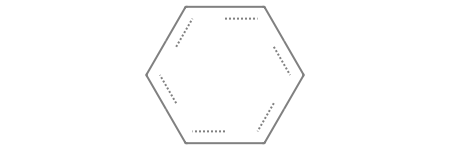

In [6]:
fragment = MolFromSmarts('c1ccccc1')
fragment

1128化合物のdelaney水溶解度データにおけるdf['Mol']列にたいして、HasSubstructMatch関数で一致するものを三項演算子で表記すると１行で終わります。565化合物のヒットがありました。

In [7]:
matches = [m for m in df['Mol'] if m.HasSubstructMatch(fragment)]
print(f'There are {len(matches)} matched molecules')

There are 565 matched molecules


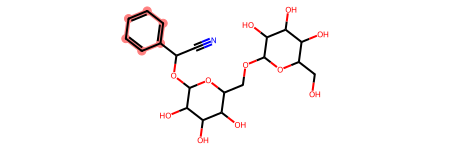

In [8]:
matches[0]

【解説】  
`HasSubstructMatch`関数は、Molオブジェクトが指定したサブストラクチャにマッチするかどうかを判定するために使用されます。具体的な利用方法は以下の通りです。

```python
from rdkit import Chem

# 検索対象の分子
target_smiles = 'CCO'
target_mol = Chem.MolFromSmiles(target_smiles)

# サブストラクチャの定義
substructure_smiles = 'CO'
substructure_mol = Chem.MolFromSmiles(substructure_smiles)

# サブストラクチャ検索
is_match = target_mol.HasSubstructMatch(substructure_mol)

if is_match:
    print("サブストラクチャが見つかりました。")
else:
    print("サブストラクチャが見つかりませんでした。")
```

上記のコードでは、`target_smiles`に対して`target_mol`を生成し、`substructure_smiles`に対して`substructure_mol`を生成しています。`HasSubstructMatch`関数を使用して、`target_mol`内に`substructure_mol`と同じサブストラクチャが存在するかどうかを確認しています。

もしサブストラクチャが見つかった場合、`is_match`はTrueになります。見つからなかった場合はFalseになります。

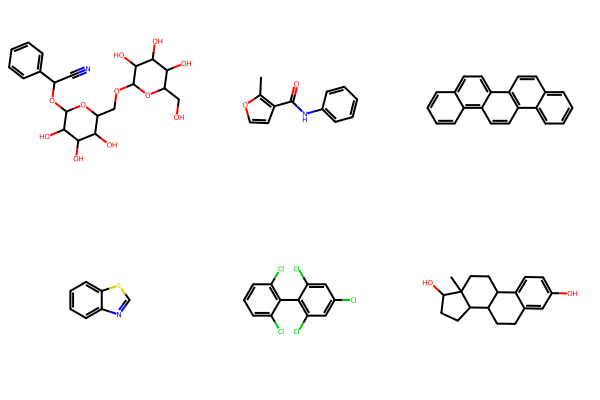

In [9]:
Draw.MolsToGridImage(matches[:6])

## 3. フラグメントカウントを使ったQSPR  （底本P55）

QSPR（Quantitative Structure-Property Relationship）は構造活性相関(QSAR)とも呼ばれ、ケモインフォマティクス分野において化学物質の分子構造と物性（性質）との間の定量的な関係を研究する手法です。QSPRは分子の構造情報を数値的な特徴量として表現し、それらの特徴量と物性データとの間に数学的な関係を見つけ出すことを目指します。

QSPRは、物性として溶解度、融点、沸点、蒸気圧、分配係数などさまざまな化学的・物理的性質を対象とすることができます。例えば、ある化合物の分子構造情報からその溶解度を予測するモデルを構築することができます。ここではフラグメント情報から溶解度との相関について主成分分析から可視化してみることにします。

### RDKit記述子（フラグメント情報）

descListに含まれているFingerPrintのうち、接頭に'fr_'がつく特徴量は、RDKitの指紋（Fingerprint）ベースの分子記述子です。これらの特徴量は、分子の構造や化学的性質に関する情報を提供します。接頭に'fr_'を含む特徴量のみをリスト化してみることにしましょう。以下に、'fr_'で始まる特徴量の意味となります。

1. `fr_CrippenO`: 分子のCrippenの酸性パラメーター（oxygen）を表す。
2. `fr_CrippenN`: 分子のCrippenの酸性パラメーター（nitrogen）を表す。
3. `fr_CrippenC`: 分子のCrippenの酸性パラメーター（carbon）を表す。
4. `fr_CrippenP`: 分子のCrippenの酸性パラメーター（phosphorus）を表す。
5. `fr_CrippenF`: 分子のCrippenの酸性パラメーター（fluorine）を表す。
6. `fr_CrippenCl`: 分子のCrippenの酸性パラメーター（chlorine）を表す。
7. `fr_CrippenBr`: 分子のCrippenの酸性パラメーター（bromine）を表す。
8. `fr_CrippenI`: 分子のCrippenの酸性パラメーター（iodine）を表す。
9. `fr_Al_COO`: アルコール基とカルボン酸基の結合パターンを表す。
10. `fr_Al_OH`: アルコール基の数を表す。
11. `fr_Al_OH_noTert`: 三次アルコール以外のアルコール基の数を表す。
12. `fr_ArN`: アリールアミン基の数を表す。
13. `fr_Ar_COO`: アリールカルボン酸基の数を表す。
14. `fr_Ar_N`: アリールアミンまたはアリールアミド基の数を表す。
15. `fr_Ar_NH`: アリールアミンまたはアリールアミドまたはアリールアミンオキシド基の数を表す。
16. `fr_Ar_OH`: アリールアルコール基の数を表す。
17. `fr_COO`: カルボン酸基の数を表す。
18. `fr_COO2`: 二重カルボン酸基の数を表す。
19. `fr_C_O`: カルボニル基の数を表す。
20. `fr_C_O_noCOO`: カルボニル基（カルボン酸基を除く）の数を表す。
21. `fr_C_S`: カルボニル硫黄結合の数を表す。
22. `fr_HBA`: 水素結合アクセプター（HBA: Hydrogen Bond Acceptor）の数を表す。
23. `fr_HBA1`: 水素結合アクセプター（1位）の数を表す。
24. `fr_HBA2`: 水素結合アクセプター（2位）の数を表す。
25. `fr_HBA3`: 水素結合アクセプター（3位）の数を表す。
26. `fr_HBD`: 水素結合ドナー（HBD: Hydrogen Bond Donor）の数を表す。
27. `fr_HBD1`: 水素結合ドナー（1位）の数を表す。
28. `fr_HBD2`: 水素結合ドナー（2位）の数を表す。
29. `fr_HBD3`: 水素結合ドナー（3位）の数を表す。
30. `fr_Imine`: イミン基の数を表す。
31. `fr_Imine_no10`: イミン基（位が10以外）の数を表す。
32. `fr_NH0`: 窒素の水素結合ドナー（位が0）の数を表す。
33. `fr_NH1`: 窒素の水素結合ドナー（位が1）の数を表す。
34. `fr_NH2`: 窒素の水素結合ドナー（位が2）の数を表す。
35. `fr_N_O`: 窒素酸化物基（NO, NO2）の数を表す。
36. `fr_Ndealkylation1`: アルキル置換された窒素の除去（位が1）の数を表す。
37. `fr_Ndealkylation2`: アルキル置換された窒素の除去（位が2）の数を表す。
38. `fr_Nhpyrrole`: ピロール窒素の水素の数を表す。
39. `fr_SH`: チオール基の数を表す。
40. `fr_aldehyde`: アルデヒド基の数を表す。
41. `fr_alkyl_carbamate`: アルキルカルバメート基の数を表す。
42. `fr_alkyl_halide`: アルキルハロゲン化物基の数を表す。
43. `fr_allylic_oxid`: アリル置換の酸化基の数を表す。
44. `fr_amide`: アミド基の数を表す。
45. `fr_amidine`: アミジン基の数を表す。
46. `fr_aniline`: アニリン基の数を表す。
47. `fr_aryl_methyl`: アリールメチル基の数を表す。
48. `fr_azide`: アジ化物基の数を表す。
49. `fr_azo`: アゾ基の数を表す。
50. `fr_barbitur`: バルビツール基の数を表す。
51. `fr_benzene`: ベンゼン環の数を表す。
52. `fr_benzodiazepine`: ベンゾジアゼピン基の数を表す。
53. `fr_bicyclic`: 二環式化合物の数を表す。
54. `fr_diazo`: ジアゾ基の数を表す。
55. `fr_dihydropyridine`: ジヒドロピリジン基の数を表す。
56. `fr_epoxide`: エポキシ基の数を表す。
57. `fr_ester`: エステル基の数を表す。
58. `fr_ether`: エーテル基の数を表す。
59. `fr_furan`: フラン基の数を表す。
60. `fr_guanido`: グアニジン基の数を表す。
61. `fr_halogen`: ハロゲン基の数を表す。
62. `fr_hdrzine`: ヒドラジン基の数を表す。
63. `fr_hdrzone`: ヒドラゾン基の数を表す。
64. `fr_imidazole`: イミダゾール基の数を表す。
65. `fr_imide`: イミド基の数を表す。
66. `fr_isocyan`: イソシアン基の数を表す。
67. `fr_isothiocyan`: イソチオシアン基の数を表す。
68. `fr_ketone`: ケトン基の数を表す。
69. `fr_ketone_Topliss`: ケトン基（Topliss分類法）の数を表す。
70. `fr_lactam`: ラクタム基の数を表す。
71. `fr_lactone`: ラクトン基の数を表す。
72. `fr_methoxy`: メトキシ基の数を表す。
73. `fr_morpholine`: モルホリン基の数を表す。
74. `fr_nitrile`: ニトリル基の数を表す。
75. `fr_nitro`: ニトロ基の数を表す。
76. `fr_nitro_arom`: 芳香族ニトロ基の数を表す。
77. `fr_nitro_arom_nonortho`: 直鎖または1位に位置しない芳香族ニトロ基の数を表す。
78. `fr_nitroso`: ニトロソ基の数を表す。
79. `fr_oxazole`: オキサゾール基の数を表す。
80. `fr_oxime`: オキシム基の数を表す。
81. `fr_para_hydroxylation`: パラ位置のヒドロキシ基の数を表す。
82. `fr_phenol`: フェノール基の数を表す。
83. `fr_phenol_noOrthoHbond`: オルト位に水素結合を形成しないフェノール基の数を表す。
84. `fr_phos_acid`: リン酸基の数を表す。
85. `fr_phos_ester`: リン酸エステル基の数を表す。
86. `fr_piperdine`: ピペリジン基の数を表す。
87. `fr_piperzine`: ピペラジン基の数を表す。
88. `fr_priamide`: プライマイド基の数を表す。
89. `fr_prisulfonamd`: プリスルホンアミド基の数を表す。
90. `fr_pyridine`: ピリジン基の数を表す。
91. `fr_quatN`: クォーターナリー窒素基の数を表す。
92. `fr_sulfide`: スルフィド基の数を表す。
93. `fr_sulfonamd`: スルホンアミド基の数を表す。
94. `fr_sulfone`: スルホン基の数を表す。
95. `fr_term_acetylene`: 端基のアセチレン基の数を表す。
96. `fr_tetrazole`: テトラゾール基の数を表す。
97. `fr_thiazole`: チアゾール基の数を表す。
98. `fr_thiocyan`: チオシアン基の数を表す。
99. `fr_thiophene`: チオフェン基の数を表す。
100. `fr_unbrch_alkane`: 非枝分かれアルカン基の数を表す。
101. `fr_urea`: ウレア基の数を表す。

接頭に'fr_'があるFingerprintを辞書型配列として規定し、そのフラグメント数を格納します。

In [10]:
listFreq = [key for key in dict(descList).keys() if key.startswith('fr_')]
list_functions = [dict(descList)[k] for k in listFreq]

`startswith()`は、Pythonの文字列メソッドの一つであり、ある文字列が指定した接頭辞（prefix）で始まるかどうかを判定するために使用されます。

このメソッドは以下のような構文を持ちます：

```python
str.startswith(prefix, start, end)
```

- `str`: 接頭辞の有無を確認したい文字列。
- `prefix`: 接頭辞として検証する文字列。
- `start` (オプション): 検索を開始する位置のインデックス。デフォルトは0。
- `end` (オプション): 検索を終了する位置のインデックス。デフォルトは文字列の末尾。

`startswith()`メソッドは、指定した文字列が接頭辞として一致する場合には`True`を返し、一致しない場合には`False`を返します。

以下はいくつかの使用例です：

```python
str1 = "Hello, world!"
print(str1.startswith("Hello"))  # True
print(str1.startswith("Hola"))   # False

str2 = "OpenAI ChatGPT"
print(str2.startswith("OpenAI", 5))  # False (位置5以降の部分で検索)
print(str2.startswith("Chat", 8, 12))  # True (位置8から12の範囲で検索)
```

`startswith()`は、文字列の前置詞を確認する際に便利です。例えば、ある文字列が特定の接頭辞で始まるかどうかを確認したり、特定のプレフィックスを持つファイル名をフィルタリングする場合などに利用されます。

部分構造の出現回数は、次の`mol2freqs`関数を定義して1128化合物のすべてに適用するようにします。

In [11]:
def mol2freqs(mol):
    " 部分構造の出現回数 "
    return list(map(lambda f: f(mol), list_functions))

In [12]:
func = mol2freqs 
X = df['Mol'].apply(func)
X

0       [0, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
1123    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1124    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, ...
1125    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1126    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1127    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: Mol, Length: 1128, dtype: object

In [13]:
from numpy import array
X2 = array(X.tolist())
X2

array([[0, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

ここでは、tolist()メソッドを使い、NumPy配列やPandasのSeriesやDataFrameなどのオブジェクトをPythonのリストに変換しています。

### 主成分分析（PCA)　（底本P57）

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

`sklearn.pipeline`モジュールの`make_pipeline`関数は、scikit-learnライブラリで機械学習パイプラインを簡単に作成するための便利な関数です。

機械学習パイプラインは、複数のデータ変換ステップとモデルの組み合わせからなる処理フローです。パイプラインには、データの前処理、特徴量の抽出、特徴量の選択、モデルの訓練などのステップが含まれることがあります。パイプラインを使用することで、これらのステップを順番に実行することができます。

`make_pipeline`関数は、複数の変換器（データ変換ステップ）とオプションの推定器（モデル）を連結してパイプラインを作成します。関数の構文は以下の通りです：

```python
make_pipeline(*steps, **kwargs)
```

- `*steps`は、パイプラインの各ステップとして使用する変換器や推定器の引数です。変換器や推定器は、データを受け取り変換または予測を行うオブジェクトでなければなりません。ステップは、パイプライン内での実行順序に従って配置されます。

- `**kwargs`は、オプションのパラメータを指定するための引数です。

以下は、`make_pipeline`関数の使用例です：

```python
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# パイプラインの作成
pipeline = make_pipeline(StandardScaler(), SVC())

# パイプラインを使用してモデルを訓練
pipeline.fit(X_train, y_train)

# パイプラインを使用して予測を行う
y_pred = pipeline.predict(X_test)
```

この例では、`StandardScaler()`を使ってデータのスケーリングを行い、`SVC()`（サポートベクターマシン分類器）を使ってモデルの訓練と予測を行っています。`make_pipeline`関数により、スケーラーと分類器が自動的にパイプライン内で連結され、順番に実行されます。

`make_pipeline`関数は、パイプライン内の各ステップに対して一意の名前を自動的に生成します。例えば、`StandardScaler()`のステップには自動的に名前が割り当てられますが、明示的に指定することも可能

です。

パイプラインを使用することで、複数のステップを効率的に実行し、モデルの訓練や予測の手続きを簡潔かつ再利用可能にすることができます。

In [15]:
pca = make_pipeline(StandardScaler(), PCA())
T = pca.fit_transform(X2)

Pythonのscikit-learnライブラリには、主成分分析（Principal Component Analysis, PCA）を実行するための`PCA`クラスがあります。`PCA`クラスの`fit_transform()`メソッドは、データセットに対してPCA変換を実行し、データを新しい座標空間に変換するために使用されます。

`fit_transform()`メソッドの具体的な動作は以下の通りです：

1. `fit_transform()`メソッドは、`PCA`クラスのインスタンスに対して呼び出されます。

2. `fit_transform()`メソッドは、与えられたデータセットを受け取り、PCAモデルを構築します。このモデルは、データセットの特徴量間の相関を解析し、主成分を抽出します。

3. データセットの各サンプルが、新しい座標空間に変換されます。変換されたデータは、元のデータセットと同じ行数を持ちながら、特徴量の数が減少します。主成分の数は、PCAモデルの設定や指定された次元数によって決まります。

4. 変換されたデータは、新しい座標空間での位置を表す特徴量の値として返されます。

以下は、`fit_transform()`メソッドの使用例です：

```python
from sklearn.decomposition import PCA

# PCAのインスタンス化
pca = PCA(n_components=2)  # 2次元の主成分を抽出

# データセットのPCA変換
transformed_data = pca.fit_transform(data)
```

この例では、`PCA`クラスのインスタンスを作成し、`n_components`パラメータを設定して主成分の数を指定しています。`fit_transform()`メソッドは、`data`というデータセットを受け取り、PCA変換を実行して新しい座標空間にデータを変換します。変換されたデータは、`transformed_data`という変数に格納されます。

PCAは次元削減手法としてよく使われます。`fit_transform()`メソッドを使用することで、高次元のデータを低次元の特徴量に変換し、データの可視化や次元の圧縮などの目的で使用することができます。

In [16]:
ratio_ = dict(pca.steps)['pca'].explained_variance_ratio_
ratio_

array([7.63478775e-02, 5.47037955e-02, 4.53185388e-02, 4.10410177e-02,
       3.93397163e-02, 3.36832123e-02, 3.20551739e-02, 3.05790799e-02,
       2.63314623e-02, 2.60405210e-02, 2.44758196e-02, 2.42752653e-02,
       2.23852440e-02, 2.05474945e-02, 2.02990948e-02, 1.84117164e-02,
       1.82974702e-02, 1.69472784e-02, 1.67634597e-02, 1.66078148e-02,
       1.62567259e-02, 1.58672724e-02, 1.55042257e-02, 1.53698279e-02,
       1.52808582e-02, 1.49749819e-02, 1.48462196e-02, 1.46272924e-02,
       1.45305383e-02, 1.44910950e-02, 1.43196781e-02, 1.42334121e-02,
       1.39869322e-02, 1.35529882e-02, 1.32365360e-02, 1.29885845e-02,
       1.21020507e-02, 1.18545263e-02, 1.13832862e-02, 1.06839591e-02,
       1.05479689e-02, 1.03479836e-02, 1.00956554e-02, 9.14842538e-03,
       8.78016418e-03, 8.15441026e-03, 7.72985693e-03, 7.11647744e-03,
       6.87960590e-03, 5.96865386e-03, 5.35664491e-03, 4.44941716e-03,
       4.02580527e-03, 3.59798351e-03, 3.30920367e-03, 2.72997491e-03,
      

PCA（Principal Component Analysis）の`explained_variance_ratio_`は、PCA変換によって抽出された各主成分の分散の割合を表す属性です。この属性は、データセットの各主成分が元のデータセットの分散のどれだけを説明しているかを示すために使用されます。

具体的には、`explained_variance_ratio_`属性は、PCA変換によって抽出された主成分の分散の割合を、昇順に格納された配列として返します。配列の各要素は、対応する主成分が元のデータの分散の何割を説明しているかを示します。

以下は、`explained_variance_ratio_`属性の使用例です：

```python
from sklearn.decomposition import PCA

# PCAのインスタンス化
pca = PCA(n_components=3)  # 3次元の主成分を抽出

# データセットのPCA変換と分散の割合の取得
transformed_data = pca.fit_transform(data)
variance_ratio = pca.explained_variance_ratio_
```

この例では、`PCA`クラスのインスタンスを作成し、`n_components`パラメータを設定して主成分の数を指定しています。`.fit_transform()`メソッドによって、`data`というデータセットをPCA変換し、新しい座標空間にデータを変換しています。その後、`explained_variance_ratio_`属性を使用して、各主成分の分散の割合を取得しています。

`explained_variance_ratio_`の合計は、全体の分散の割合を示し、一般的には1に近づきます。これを使用することで、主成分がデータの分散のどれだけをカバーしているかを把握することができます。たとえば、`explained_variance_ratio_`が`[0.6, 0.3, 0.1]`となっていれば、最初の主成分がデータの60％の分散を説明し、2番目の主成分が30％、3番目の主成分が10％を説明していることを示します。

この情報は、主成分の数を選択する際や、次元削減の目的でPCAを使用する際に役立ちます。高い分散の割合を持つ主成分の数を選択することで、元のデータセットの情報をできるだけ保持しながら、低次元の特徴空間にデータを変換することができます。

### 主成分分析（PCA)の可視化

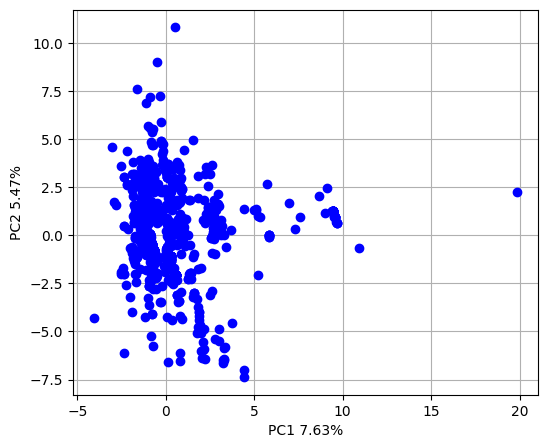

In [17]:
# 図5.2(a)　PCA第一主成分、第二主成分
fig = plt.subplots(figsize=(6, 5))
plt.plot(T[:,0], T[:,1], 'o', color ='blue')

plt.xlabel('PC1 {:.2f}%'.format(ratio_[0]*100))
plt.ylabel('PC2 {:.2f}%'.format(ratio_[1]*100))

plt.grid()
plt.show()

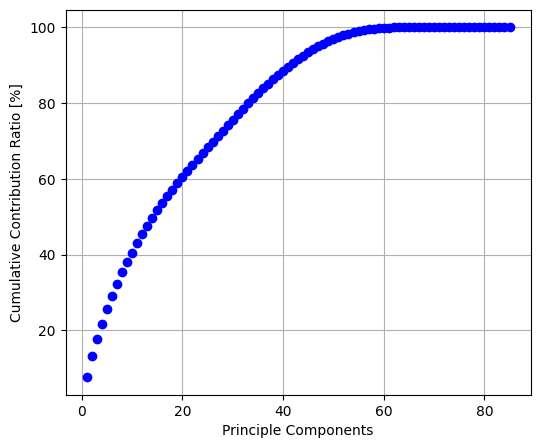

In [18]:
# 図5.2(b)　累積寄与率

from numpy import cumsum, arange
fig = plt.subplots(figsize=(6, 5))

plt.plot(arange(1,1+len(ratio_)), 100*cumsum( ratio_ ),'o', color ='blue')

plt.xlabel('Principle Components')
plt.ylabel('Cumulative Contribution Ratio [%]')

plt.grid()
plt.show()

フラグメントの第一主成分、第二主成分と溶解度の関係を見やすくするため、各点に溶解度情報を含めてカラーバー表示をしてみることにしましょう。

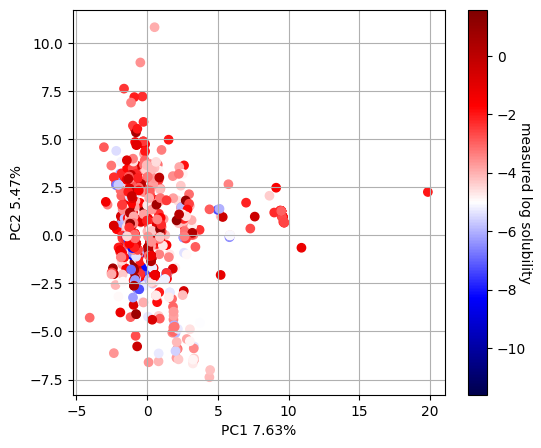

In [19]:
# 図5.2(a)　PCA第一主成分、第二主成分

fig = plt.subplots(figsize=(6, 5))

y = df['measured log solubility in mols per litre'].values

plt.scatter(T[:,0],T[:,1], c=y, cmap=plt.cm.seismic)
cbar = plt.colorbar()

plt.xlabel('PC1 {:.2f}%'.format(ratio_[0]*100))
plt.ylabel('PC2 {:.2f}%'.format(ratio_[1]*100))

cbar.set_label('measured log solubility', rotation = 270)

plt.grid()
plt.show()

このようにRDKit記述子のうち、フラグメント情報のみからは溶解度についてはクラスタリングすることはできなさそうです。

### RDKit記述子（フル）
次のフラグメントのみならず、RDKit記述子を全て使って同じくQSPRを見てみましょう。

In [20]:
df = pd.read_csv('./data/delaney-solubility/delaney-processed.csv')

In [21]:
list_functions = list(dict(descList).values())

In [22]:
def mol2rdkit_desc(mol):
    " RDKit descriptors "
    return list(map(lambda f: f(mol), list_functions))

In [23]:
func = mol2rdkit_desc

df['Mol'] = df.smiles.apply(MolFromSmiles)

X = df.Mol.apply(func)
X2 = array(X.tolist())

In [24]:
pca = make_pipeline(StandardScaler(), PCA())
T = pca.fit_transform(X2)

In [25]:
ratio_ = dict(pca.steps)['pca'].explained_variance_ratio_

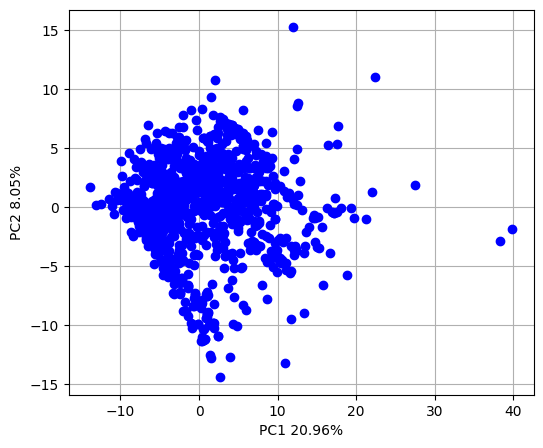

In [26]:
# 図5.3(a)　PCA第一主成分、第二主成分
fig = plt.subplots(figsize=(6, 5))
plt.plot(T[:,0], T[:,1], 'o', color ='blue')

plt.xlabel('PC1 {:.2f}%'.format(ratio_[0]*100))
plt.ylabel('PC2 {:.2f}%'.format(ratio_[1]*100))

plt.grid()
plt.show()

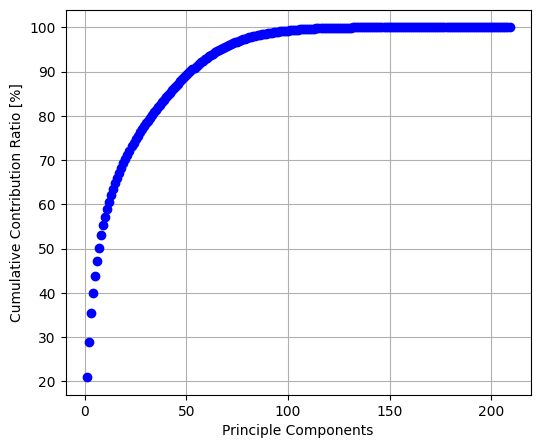

In [27]:
# 図5.3(b)　累積寄与率
fig = plt.subplots(figsize=(6, 5))

plt.plot(arange(1,1+len(ratio_)), 100*cumsum( ratio_ ),'o', color ='blue')
         
plt.xlabel('Principle Components')
plt.ylabel('Cumulative Contribution Ratio [%]')

plt.grid()

plt.show()

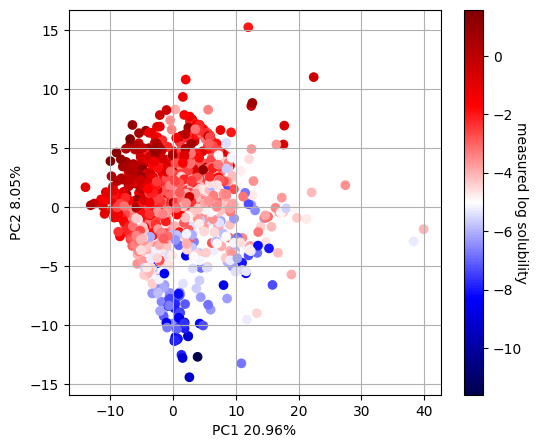

In [28]:
# 図5.2(a)　PCA第一主成分、第二主成分

fig = plt.subplots(figsize=(6, 5))
y = df['measured log solubility in mols per litre'].values

plt.scatter(T[:,0],T[:,1], c=y, cmap=plt.cm.seismic)
cbar = plt.colorbar()

plt.xlabel('PC1 {:.2f}%'.format(ratio_[0]*100))
plt.ylabel('PC2 {:.2f}%'.format(ratio_[1]*100))

cbar.set_label('measured log solubility', rotation = 270)

plt.grid()
plt.show()

RDKit記述子の部分構造だけでなく物性値も含めることで、溶解度については大きく二極化させることができました。この場合は、クラスタリングすることができそうです。また、このことから物性記述子側に予測精度を高める記述子＝特徴量が含まれていることを示唆します。

### Mordred Fingerprint

Mordred（モードレッド）[1] は、大阪大学の高木達也教授らのグループで開発されたPythonで実装されたオープンソースのライブラリで、ケモインフォマテックスのための記述子を計算するツールです。このライブラリでは2 次元、3 次元を合わせ約 2,000 の記述子が算出できます。

[1] Moriwaki H, Tian Y-S, Kawashita N, Takagi T, "Mordred: a molecular descriptor calculator". Journal of Cheminformatics 10:4 (2018) . doi: 10.1186/s13321-018-0258-y

【記述子の一覧】
https://mordred-descriptor.github.io/documentation/master/descriptors.html

In [29]:
from mordred import Calculator as mord_calc, descriptors

In [30]:
df = pd.read_csv('./data/delaney-solubility/delaney-processed.csv')
df['Mol'] = df.smiles.apply(MolFromSmiles)

In [31]:
calc2d = mord_calc(descriptors, ignore_3D=False)

（次の処理時間はPCのスペックにもよりますが、Core i7クラスで8分ほどかかります）

In [32]:
descs2d = df.Mol.apply(calc2d)
dfX = calc2d.pandas(df.Mol)
print('data shape', dfX.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 1128/1128 [00:39<00:00, 28.61it/s]


data shape (1128, 1826)


Mordred記述子のcalc2dだけでも1826次元（1826項目）の記述子を含むことがわかります。また、記述子には”NaN”を含むものがありますので、それらは排除する処理を次の「is_nonnan」で行います。

In [33]:
# 標準化
sc = StandardScaler()
Xsc = sc.fit_transform(dfX)

is_nonnan = np.sum(np.isnan(Xsc), axis=0)==0

以後のPCAの処理は上記と全く同じです。

In [34]:
# 主成分分析
pca = make_pipeline(StandardScaler(),  PCA())
T = pca.fit_transform(dfX.iloc[:, np.where(is_nonnan)[0]])

In [35]:
#寄与率の計算
contrib_=pca.steps[-1][-1].explained_variance_ratio_

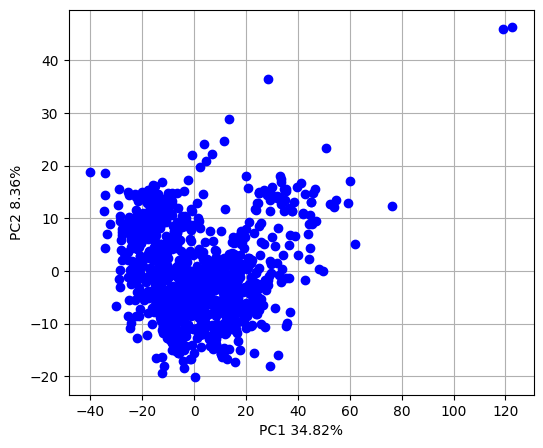

In [36]:
# 図5.4(a)　PCA第一主成分、第二主成分
fig = plt.subplots(figsize=(6, 5))
plt.plot(*T[:,:2].T, 'o',color='blue')

plt.xlabel('PC1 {:.2f}%'.format(100*contrib_[0]))
plt.ylabel('PC2 {:.2f}%'.format(100*contrib_[1]))

plt.grid()
plt.show()

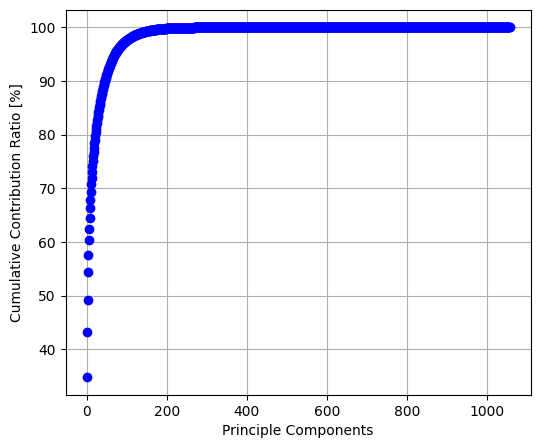

In [37]:
# 図5.4(b)　累積寄与率
fig = plt.subplots(figsize=(6, 5))

plt.plot(np.cumsum(contrib_)*100, 'o',color='blue')
plt.xlabel('Principle Components')
plt.ylabel('Cumulative Contribution Ratio [%]')
plt.grid()
plt.show()

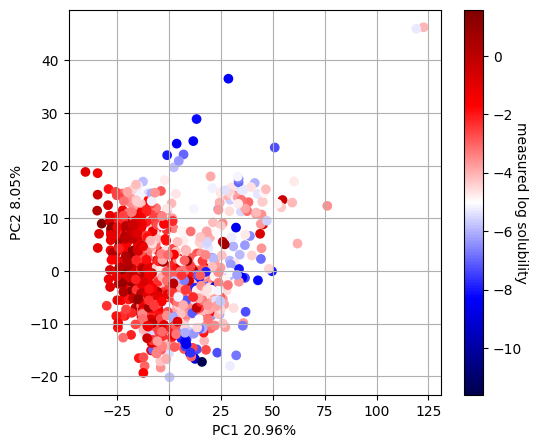

In [38]:
# 図5.2(a)　PCA第一主成分、第二主成分

fig = plt.subplots(figsize=(6, 5))
y = df['measured log solubility in mols per litre'].values

plt.scatter(T[:,0],T[:,1], c=y, cmap=plt.cm.seismic)
cbar = plt.colorbar()

plt.xlabel('PC1 {:.2f}%'.format(ratio_[0]*100))
plt.ylabel('PC2 {:.2f}%'.format(ratio_[1]*100))

cbar.set_label('measured log solubility', rotation = 270)

plt.grid()
plt.show()

# 次回  
https://colab.research.google.com/github/ARIM-Training/Training_python_4/blob/main/第5回_解析例1_触媒活性.ipynb
